### Adding custom layer on top of pre-trained model
Similar to "03 - Using Bottleneck Features" but instead here we will be training on whole model at one go

***
This has a drawback as compared to using Bottleneck features as for each epoch cycle it takes a lot more time than the other one.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [14]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.applications.vgg16 import decode_predictions
from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, BatchNormalization, Dropout, Flatten, merge, Reshape, Activation
from keras.models import Sequential, Model
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import applications
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.preprocessing.image import ImageDataGenerator

/home/arpit/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
model_vgg16 = VGG16(weights = "imagenet", include_top=False, 
                           input_shape = (150, 150, 3))

In [5]:
# Freeze all the convolutional layers
for layer in model_vgg16.layers:
    layer.trainable = False

In [6]:
# Add custom Dense layer on top of frozen layers
x = model_vgg16.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
# x = Dropout(0.4)(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(10, activation="softmax")(x)

In [7]:
# Create the complete model
model = Model(input = model_vgg16.input, output = predictions)

/home/arpit/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [8]:
# model = multi_gpu_model(model, gpus=2)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [10]:
batch_size = 64

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=True,
        seed = 42)  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle = True, 
        seed = 42)

Found 44000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.


In [12]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=44000 // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=5000 // batch_size)

# always save your weights after training or during training
# model.save_weights('first_try.h5')

Epoch 1/5
687/687 [==============================] - 137s 199ms/step - loss: 0.2207 - acc: 0.9288 - val_loss: 0.2641 - val_acc: 0.9235
Epoch 2/5
687/687 [==============================] - 136s 198ms/step - loss: 0.1513 - acc: 0.9522 - val_loss: 0.2746 - val_acc: 0.9145
Epoch 3/5
687/687 [==============================] - 136s 198ms/step - loss: 0.1233 - acc: 0.9611 - val_loss: 0.0909 - val_acc: 0.9720
Epoch 4/5
687/687 [==============================] - 136s 198ms/step - loss: 0.1133 - acc: 0.9655 - val_loss: 0.0954 - val_acc: 0.9706
Epoch 5/5
687/687 [==============================] - 136s 198ms/step - loss: 0.1079 - acc: 0.9674 - val_loss: 0.1282 - val_acc: 0.9631


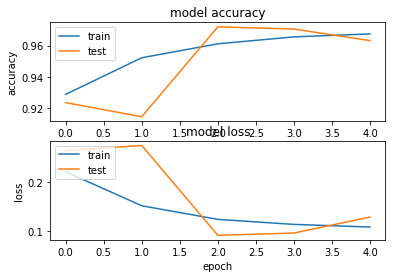

In [15]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

In [16]:
model.evaluate_generator(generator=validation_generator)

[0.12799456959534436, 0.9632]

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
test_generator = test_datagen.flow_from_directory(
    directory="data/test",
    target_size=(150, 150),
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 21000 images belonging to 1 classes.


In [19]:
%%time
test_generator.reset()
pred=model.predict_generator(test_generator,verbose=1)

21000/21000 [==============================] - 164s 8ms/step
CPU times: user 2min 42s, sys: 16.1 s, total: 2min 58s
Wall time: 2min 43s


In [20]:
predicted_class_indices=np.argmax(pred,axis=1)

In [21]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [22]:
predictions = [labels[k] for k in predicted_class_indices]

In [23]:
filenames=test_generator.filenames

In [25]:
results=pd.DataFrame({"filename":filenames,
                      "label":predictions})
results.to_csv("results/results_custom_dense.csv",index=False)